In [13]:
import numpy as np
import random
import numpy.linalg as la
import matplotlib.pyplot as plt
import math
from collections import Counter
from typing import List



def chain_builder_2L(N, rho):
    """
    having chain be a numpy array that the first column is the ferminonic number of the pair and the second column 
    is the Majorana operator which can be assigned randomly at contact to simulate quantum randomness.
    third column is the pair index
    """
    if N % 2 != 0:
        raise ValueError("N must be even for a Majorana chain.")
    chain = np.empty((N * rho, 3, 2), dtype=object)
    for i in range(N):
        chain[i * rho][0][0] = 1 # initially all pairs have fermion number 1
        chain[i * rho][1][0] = True
        chain[i * rho][2][0] = int(i/2) # index for pair (i,j), where i<j, using i to denote the Majorana j is paired with.
        chain[i * rho][0][1] = 1 # initially all pairs have fermion number 1
        chain[i * rho][1][1] = True
        chain[i * rho][2][1] = int(i/2) # index for pair (i,j), where i<j, using i to denote the Majorana j is paired with.
    return chain

def hopping_annihilate_2L(chain, p):
    N = chain.shape[0]  # Number of sites in the chain
    index0 = np.where(chain[:,1, 0]==True)[0] # get the index of Majorana operators
    for m in range(len(index0)):
        i = random.choice(index0)  

        hop_direction0 = random.choice([-1, 1])
        if  chain[:, 2, 0].tolist().count(None) == N: #if all sites are empty

            return chain, 0
        
        r = random.random()
        if r < p:
            if hop_direction0 >0 and chain[i ][2][1] != None: #if the site is empty
            
                rows_i = np.where(chain[:, 2, 0] == chain[i][2][0])[0]
                rows = np.where(chain[:, 2, 1] == chain[(i+hop_direction0) % N][2][0])[0]
                outside_index_i = [x for x in rows_i if x != i][0]
                outside_index = [x for x in rows if x != (i+hop_direction0)%N][0]
                ferminoic_parity = chain[i][0][0]
                chain[i][0][0] = chain[(i+hop_direction0) % N][0][1]
                chain[(i+hop_direction0) % N][0][1] = ferminoic_parity
                return chain, 0, 0
        if chain[i][0][0] == None: #if the site is empty
            pass

        elif chain[(i+hop_direction0) % N][0][0] == None: #if the site to arrive is empty
            chain[(i+hop_direction0) % N][0][0] = chain[i][0][0]
            chain[i][0][0] = None
            chain[(i+hop_direction0) % N][1][0] = chain[i][1][0]
            chain[i][1][0] = None
            chain[(i+hop_direction0) % N][2][0] = chain[i][2][0]
            chain[i][2][0] = None
            pass

        elif chain[(i+hop_direction0) % N][2][0] == chain[i][2][0]:  #if paired under periodic boundary condition
            if chain[i][0][0] == 0 and chain[(i+hop_direction0) % N][0][0] == 0:
                chain[i][0][0] = None
                chain[(i+hop_direction0) % N][0][0] = None
                chain[i][1][0] = None
                chain[(i+hop_direction0) % N][1][0] = None
                chain[i][2][0] = None
                chain[(i+hop_direction0) % N][2][0] = None
        
        elif chain[i][2][0] !=  chain[(i+hop_direction0) % N][2][0] :
            
            # get the index of paired Majorana
            rows_i = np.where(chain[:, 2, 0] == chain[i][2][0])[0]
            rows = np.where(chain[:, 2, 0] == chain[(i+hop_direction0) % N][2][0])[0]
            outside_index_i = [x for x in rows_i if x != i][0]
            outside_index = [x for x in rows if x != (i+hop_direction0)%N][0]
            if chain[i][0][0] == 0:
                chain[i][0][0] = None
                chain[i][1][0] = None
                chain[i][2][0] = None
                chain[outside_index_i][0][0] = None
                chain[outside_index_i][1][0] = None
                chain[outside_index_i][2][0] = None

            if chain[(i+hop_direction0) % N][0][0] == 0:
                chain[(i+hop_direction0) % N][0][0] = None
                chain[(i+hop_direction0) % N][1][0] = None
                chain[(i+hop_direction0) % N][2][0] = None
                chain[outside_index][0][0] = None
                chain[outside_index][1][0] = None
                chain[outside_index][2][0] = None

            if chain[i][0][0] == 1 and chain[(i+hop_direction0) % N][0][0] == 1:
                # calculate the ferminon number of new arcs
                n_sum = chain[i][0][0] + chain[(i+hop_direction0) % N][0][0]
                ferminon_number = random.choice([0, 1])
                
                if ferminon_number == 0:
                    chain[i][0][0] = None
                    chain[(i+hop_direction0) % N][0][0] = None
                    chain[i][1][0] = None
                    chain[(i+hop_direction0) % N][1][0] = None
                    chain[i][2][0] = None
                    chain[(i+hop_direction0) % N][2][0] = None
                    chain[outside_index_i][0][0] = None
                    chain[outside_index_i][1][0] = None
                    chain[outside_index_i][2][0] = None
                    chain[outside_index][0][0] = None
                    chain[outside_index][1][0] = None
                    chain[outside_index][2][0] = None

                else:
                    chain[i][0][0] = ferminon_number
                    chain[(i+hop_direction0) % N][0][0] = ferminon_number
                    chain[outside_index_i][0][0] = (n_sum-ferminon_number) % 2 # conservation of ferminon number
                    chain[outside_index][0][0] = (n_sum-ferminon_number) % 2

                    # update the pairing index
                    
                    pair_index = chain[(i+hop_direction0) % N][2][0]
                    pair_index_i = chain[i][2][0]
                    min_index = min(pair_index, pair_index_i)
                    max_index = max(pair_index, pair_index_i)

                    if  i == min(i, (i+hop_direction0) % N, outside_index_i, outside_index) or (i+hop_direction0) % N == min(i, (i+hop_direction0) % N, outside_index_i, outside_index):
                        chain[i][2][0] = min_index
                        chain[(i+hop_direction0) % N][2][0] = min_index
                        chain[outside_index_i][2][0] = max_index
                        chain[outside_index][2][0] = max_index
                    else:
                        chain[i][2][0] = max_index
                        chain[(i+hop_direction0) % N][2][0] = max_index
                        chain[outside_index_i][2][0] = min_index
                        chain[outside_index][2][0] = min_index
                
    index1 = np.where(chain[:,1, 1]==True)[0] # get the index of Majorana operators
    for j in index1:
    
        hop_direction1 = random.choice([-1, 1])
        if  chain[:, 2, 1].tolist().count(None) == N: #if all sites are empty

            return chain, 0, 0
        if chain[j][0][1] == None: #if the site is empty
            pass

        elif chain[(j+hop_direction1) % N][0][1] == None: #if the site to arrive is empty
            chain[(j+hop_direction1) % N][0][1] = chain[j][0][1]
            chain[j][0][1] = None
            chain[(j+hop_direction1) % N][1][1] = chain[j][1][1]
            chain[j][1][1] = None
            chain[(j+hop_direction1) % N][2][1] = chain[j][2][1]
            chain[j][2][1] = None
            pass

        elif chain[(j+hop_direction1) % N][2][1] == chain[j][2][1]:  #if paired under periodic boundary condition
            if chain[j][0][1] == 0 and chain[(j+hop_direction1) % N][0][1] == 0:
                chain[j][0][1] = None
                chain[(j+hop_direction1) % N][0][1] = None
                chain[j][1][1] = None
                chain[(j+hop_direction1) % N][1][1] = None
                chain[j][2][1] = None
                chain[(j+hop_direction1) % N][2][1] = None
        
        elif chain[j][2][1] !=  chain[(j+hop_direction1) % N][2][1]:
        
            # get the index of paired Majorana
            rows_j = np.where(chain[:, 2, 1] == chain[j][2][1])[0]
            rows = np.where(chain[:, 2, 1] == chain[(j+hop_direction1) % N][2][1])[0]
            outside_index_j = [x for x in rows_j if x != j][0]
            outside_index = [x for x in rows if x != (j+hop_direction1)%N][0]

            if chain[j][0][1] == 0:
                chain[j][0][1] = None
                chain[j][1][1] = None
                chain[j][2][1] = None
                chain[outside_index_j][0][1] = None
                chain[outside_index_j][1][1] = None
                chain[outside_index_j][2][1] = None
            if chain[(j+hop_direction1) % N][0][1] == 0:
                chain[(j+hop_direction1) % N][0][1] = None
                chain[(j+hop_direction1) % N][1][1] = None
                chain[(j+hop_direction1) % N][2][1] = None
                chain[outside_index][0][1] = None
                chain[outside_index][1][1] = None
                chain[outside_index][2][1] = None
            # calculate the ferminon number of new arcs
            if chain[j][0][1] ==1 and chain[(j+hop_direction1) % N][0][1] == 1:
                n_sum1 = chain[j][0][1] + chain[(j+hop_direction1) % N][0][1]
                ferminon_number1 = random.choice([0, 1])
            
                if ferminon_number1 == 0:
                    chain[j][0][1] = None
                    chain[(j+hop_direction1) % N][0][1] = None
                    chain[j][1][1] = None
                    chain[(j+hop_direction1) % N][1][1] = None
                    chain[j][2][1] = None
                    chain[(j+hop_direction1) % N][2][1] = None
                    chain[outside_index_j][0][1] = None
                    chain[outside_index_j][1][1] = None
                    chain[outside_index_j][2][1] = None
                    chain[outside_index][0][1] = None
                    chain[outside_index][1][1] = None
                    chain[outside_index][2][1] = None

                else:
                    chain[j][0][1] = ferminon_number1
                    chain[(j+hop_direction1) % N][0][1] = ferminon_number1
                    chain[outside_index_j][0][1] = (n_sum1-ferminon_number1) % 2 # conservation of ferminon number
                    chain[outside_index][0][1] = (n_sum1-ferminon_number1) % 2

                    # update the pairing index
                    
                    pair_index1 = chain[(j+hop_direction1) % N][2][1]
                    pair_index_j = chain[j][2][1]
                    min_index = min(pair_index1, pair_index_j)
                    max_index = max(pair_index1, pair_index_j)

                    if  j == min(j, (j+hop_direction1) % N, outside_index_j, outside_index) or (j+hop_direction1) % N == min(j, (j+hop_direction1) % N, outside_index_j, outside_index):
                        chain[j][2][1] = min_index
                        chain[(j+hop_direction1) % N][2][1] = min_index
                        chain[outside_index_j][2][1] = max_index
                        chain[outside_index][2][1] = max_index
                    else:
                        chain[j][2][1] = max_index
                        chain[(j+hop_direction1) % N][2][1] = max_index
                        chain[outside_index_j][2][1] = min_index
                        chain[outside_index][2][1] = min_index
    p0 = chain[:, 2, 0]   # shape (N,)
    p1 = chain[:, 2, 1]

    # collect unique, non-None pairing indices
    uniq0 = set(idx for idx in p0 if idx is not None)
    uniq1 = set(idx for idx in p1 if idx is not None)

    for pair0 in uniq0:
        # find the two layer0 sites
        i_sites = [i for i, x in enumerate(p0) if x == pair0]
        if len(i_sites) != 2:
            continue   # skip any malformed pairing
        iA, iB = i_sites
        lo, hi = min(iA, iB), max(iA, iB)

        for pair1 in uniq1:
            # find the two layer1 sites
            j_sites = [j for j, x in enumerate(p1) if x == pair1]
            if len(j_sites) != 2:
                continue
            jC, jD = j_sites

            # check if either jC or jD falls in the closed interval [lo, hi]
            if lo <= jC <= hi or lo <= jD <= hi:
                r = random.random()
                if r < p:
                    ferminoic_parity = chain[iA][0][0]
                    chain[iA][0][0] = chain[jC][0][1]
                    chain[iB][0][0] = chain[jD][0][1]
                    chain[jC][0][1] = ferminoic_parity
                    chain[jD][0][1] = ferminoic_parity
                
    density0 = N - chain[:,2,0].tolist().count(None) # Count the number of empty sites
    density1 = N - chain[:,2,1].tolist().count(None) # Count the number of empty sites
    # density = [density0, density1]
    return chain, density0 , density1
    

def evolution_annihilate(chain, t, p):
    """
    Simulates the evolution of the Majorana chain over time t.
    The function modifies the chain in place.
    """
    density = np.zeros((t, 2), dtype=int)  # Initialize density array for two Majorana operators
    times = [k for k in range(t)]
    for k in range(t):
        
        chain, density0, density1= hopping_annihilate(chain, p)
        density[k][0] = density0
        density[k][1] = density1
    return times, density

def calculate_pair_distances(chain):
    """
    Computes the arc length of Majorana pairs
    
    Returns:
      pair_data: a list of tuples (pair_index, distance)
      distance_counts: a dictionary mapping distance -> count of pairs with that distance
    """
    pair_positions = {}
    # Loop over each row in the chain and record its index based on its pairing index (third column)
    for i, row in enumerate(chain):
        pair_idx = row[2]
        if pair_idx is None:
            pass
        if pair_idx in pair_positions:
            pair_positions[pair_idx].append(i)
        else:
            pair_positions[pair_idx] = [i]
    
    pair_data = []    
    distance_counts = {} 
    
    for pair_idx, positions in pair_positions.items():
        if len(positions) == 2:
            d = abs(positions[1] - positions[0])
            pair_data.append((pair_idx, d))
            distance_counts[d] = distance_counts.get(d, 0) + 1
        else:
            # If there are not exactly two entries for a pair index, issue a warning.
            print(f"Warning: Pair index {pair_idx} appears {len(positions)} times (expected 2).")
    
    return pair_data, distance_counts
     

def S_A(chain, R):
    """
    Count “whole” and “half” pairs in lst[start:end].

    - If both occurrences of a value fall inside [start,end), it contributes 1.
    - If exactly one occurrence falls inside, it contributes 0.5.
    """
    S_A_ = 0.0
    start = (len(chain)-R)//2
    end = start + R -1
    window = chain[start:end,2]
    cnt = Counter(window)
    S_A_ = sum(min(c, 2) * 0.5 for c in cnt.values())
    return S_A_



In [19]:
def hopping_annihilate_2L(chain, p):
    N = chain.shape[0]  # Number of sites in the chain
    index0 = np.where(chain[:,1, 0]==True)[0] # get the index of Majorana operators
    for m in range(len(index0)):
        i = random.choice(index0)
        hop_direction0 = random.choice([-1, 1])
        if  chain[:, 2, 0].tolist().count(None) == N: #if all sites are empty

            return chain, 0, 0
        
        if chain[i][0][0] == None: #if the site is empty
            pass

        elif chain[(i+hop_direction0) % N][0][0] == None: #if the site to arrive is empty
            
            r = random.random()
            if r < p:
                if hop_direction0 <0 and chain[(i+hop_direction0) % N ][2][1] != None: #if the site is empty
                    # get the index of paired Majorana
                    pair_i = np.where(chain[:, 2, 0] == chain[i][2][0])[0]
                    pair_j = np.where(chain[:, 2, 1] == chain[(i+hop_direction0) % N][2][1])[0]
                    partner_i = [x for x in pair_i if x != i][0]
                    partner_j = [x for x in pair_j if x != (i+hop_direction0)%N][0]
                    
                    if partner_j == None:
                        raise ValueError("Partner Majorana is None, check the chain structure.")
                    # flip the fermionic parity
                    chain[i][0][0] = (chain[i][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[(i+hop_direction0) % N][0][1] = (chain[(i+hop_direction0) % N][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

                elif hop_direction0 >0 and chain[i][2][1] != None:
                    # get the index of paired Majorana
                    pair_i = np.where(chain[:, 2, 0] == chain[i][2][0])[0]
                    pair_j = np.where(chain[:, 2, 1] == chain[i][2][1])[0]
                    partner_i = [x for x in pair_i if x != i][0]
                    partner_j = [x for x in pair_j if x != i][0]

                    # flip the fermionic parity
                    chain[i][0][0] = (chain[i][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[i][0][1] = (chain[i][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

            chain[(i+hop_direction0) % N][0][0] = chain[i][0][0]
            chain[i][0][0] = None
            chain[(i+hop_direction0) % N][1][0] = chain[i][1][0]
            chain[i][1][0] = None
            chain[(i+hop_direction0) % N][2][0] = chain[i][2][0]
            chain[i][2][0] = None

        elif chain[(i+hop_direction0) % N][2][0] == chain[i][2][0]:  #if paired under periodic boundary condition

            r = random.random()
            if r < p:
                if hop_direction0 <0 and chain[(i+hop_direction0) % N ][2][1] != None: #if the site is empty
                    # get the index of paired Majorana
                    pair_i = np.where(chain[:, 2, 0] == chain[i][2][0])[0]
                    pair_j = np.where(chain[:, 2, 1] == chain[(i+hop_direction0) % N][2][1])[0]
                    partner_i = [x for x in pair_i if x != i][0]
                    partner_j = [x for x in pair_j if x != (i+hop_direction0)%N][0]

                    # flip the fermionic parity
                    chain[i][0][0] = (chain[i][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[(i+hop_direction0) % N][0][1] = (chain[(i+hop_direction0) % N][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

                elif hop_direction0 >0 and chain[i][2][1] != None:
                    # get the index of paired Majorana
                    pair_i = np.where(chain[:, 2, 0] == chain[i][2][0])[0]
                    pair_j = np.where(chain[:, 2, 1] == chain[i][2][1])[0]
                    partner_i = [x for x in pair_i if x != i][0]
                    partner_j = [x for x in pair_j if x != i][0]

                    # flip the fermionic parity
                    chain[i][0][0] = (chain[i][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[i][0][1] = (chain[i][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

            if chain[i][0][0] == 0 and chain[(i+hop_direction0) % N][0][0] == 0:
                
                chain[i][0][0] = None
                chain[(i+hop_direction0) % N][0][0] = None
                chain[i][1][0] = None
                chain[(i+hop_direction0) % N][1][0] = None
                chain[i][2][0] = None
                chain[(i+hop_direction0) % N][2][0] = None
            
            
        
        elif chain[i][2][0] !=  chain[(i+hop_direction0) % N][2][0] :


            # get the index of paired Majorana
            rows_i = np.where(chain[:, 2, 0] == chain[i][2][0])[0]

            if len(rows_i) == 0:
                raise ValueError("No paired Majorana found for site i.")
            
            rows = np.where(chain[:, 2, 0] == chain[(i+hop_direction0) % N][2][0])[0]
            outside_index_i = [x for x in rows_i if x != i][0]
            outside_index = [x for x in rows if x != (i+hop_direction0)%N][0]
            n_sum = chain[i][0][0] + chain[(i+hop_direction0) % N][0][0]
            ferminon_number = random.choice([0, 1])
            chain[i][0][0] = ferminon_number
            chain[(i+hop_direction0) % N][0][0] = ferminon_number

            # braiding
            r = random.random()
            if r < p:
                if hop_direction0 <0 and chain[(i+hop_direction0) % N ][2][1] != None: #if the site is empty
                    # get the index of paired Majorana
                    pair_i = np.where(chain[:, 2, 0] == chain[i][2][0])[0]
                    pair_j = np.where(chain[:, 2, 1] == chain[(i+hop_direction0) % N][2][1])[0]
                    partner_i = [x for x in pair_i if x != i][0]
                    partner_j = [x for x in pair_j if x != (i+hop_direction0)%N][0]

                    # flip the fermionic parity
                    chain[i][0][0] = (chain[i][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[(i+hop_direction0) % N][0][1] = (chain[(i+hop_direction0) % N][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

                elif hop_direction0 >0 and chain[i][2][1] != None:
                    # get the index of paired Majorana
                    pair_i = np.where(chain[:, 2, 0] == chain[i][2][0])[0]
                    pair_j = np.where(chain[:, 2, 1] == chain[i][2][1])[0]
                    partner_i = [x for x in pair_i if x != i][0]
                    partner_j = [x for x in pair_j if x != i][0]

                    # flip the fermionic parity
                    chain[i][0][0] = (chain[i][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[i][0][1] = (chain[i][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

            pair_index = chain[(i+hop_direction0) % N][2][0]
            pair_index_i = chain[i][2][0]
            min_index = min(pair_index, pair_index_i)
            max_index = max(pair_index, pair_index_i)

            if chain[i][0][0] == 0 and chain[(i+hop_direction0) % N][0][0] == 0:
                # annihilate the collided pair
                chain[i][0][0] = None
                chain[i][1][0] = None
                chain[i][2][0] = None
                chain[(i+hop_direction0) % N][0][0] = None
                chain[(i+hop_direction0) % N][1][0] = None
                chain[(i+hop_direction0) % N][2][0] = None

                # update the partner pair
                chain[outside_index_i][0][0] = n_sum % 2
                chain[outside_index_i][1][0] = True
                chain[outside_index_i][2][0] = min_index
                chain[outside_index][0][0] = n_sum % 2
                chain[outside_index][1][0] = True
                chain[outside_index][2][0] = min_index

        

            elif chain[i][0][0] == 1 and chain[(i+hop_direction0) % N][0][0] == 1:
                # calculate the ferminon number of new arcs
                chain[outside_index_i][0][0] = (n_sum -1) % 2
                chain[outside_index][0][0] = (n_sum -1) % 2
                

                if  i == min(i, (i+hop_direction0) % N, outside_index_i, outside_index) or (i+hop_direction0) % N == min(i, (i+hop_direction0) % N, outside_index_i, outside_index):
                    chain[i][2][0] = min_index
                    chain[(i+hop_direction0) % N][2][0] = min_index
                    chain[outside_index_i][2][0] = max_index
                    chain[outside_index][2][0] = max_index
                else:
                    chain[i][2][0] = max_index
                    chain[(i+hop_direction0) % N][2][0] = max_index
                    chain[outside_index_i][2][0] = min_index
                    chain[outside_index][2][0] = min_index

                

    index1 = np.where(chain[:,1, 1]==True)[0] # get the index of Majorana operators
    for j in range(len(index1)):
        j = random.choice(index1)
        hop_direction1 = random.choice([-1, 1])
        if  chain[:, 2, 1].tolist().count(None) == N: #if all sites are empty

            return chain, 0, 0
        
        if chain[j][0][1] == None: #if the site is empty
            pass

        elif chain[(j+hop_direction1) % N][0][1] == None: #if the site to arrive is empty

            q = random.random()
            if q < p:
                if hop_direction1 >0 and chain[(j+hop_direction1) % N ][2][0] != None: #if the site is empty
                    # get the index of paired Majorana
                    pair_j = np.where(chain[:, 2, 1] == chain[j][2][1])[0]
                    pair_i = np.where(chain[:, 2, 0] == chain[(j+hop_direction1) % N][2][0])[0]
                    partner_j = [x for x in pair_j if x != j][0]
                    partner_i = [x for x in pair_i if x != (j+hop_direction1)%N][0]

                    # flip the fermionic parity
                    chain[(j+hop_direction1) % N][0][0] = (chain[(j+hop_direction1) % N][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[j][0][1] = (chain[j][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

                elif hop_direction1 <0 and chain[j][2][0] != None:
                    # get the index of paired Majorana
                    pair_i = np.where(chain[:, 2, 0] == chain[j][2][0])[0]
                    pair_j = np.where(chain[:, 2, 1] == chain[j][2][1])[0]
                    partner_i = [x for x in pair_i if x != j][0]
                    partner_j = [x for x in pair_j if x != j][0]

                    # flip the fermionic parity
                    chain[j][0][0] = (chain[j][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[j][0][1] = (chain[j][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

            chain[(j+hop_direction1) % N][0][1] = chain[j][0][1]
            chain[j][0][1] = None
            chain[(j+hop_direction1) % N][1][1] = chain[j][1][1]
            chain[j][1][1] = None
            chain[(j+hop_direction1) % N][2][1] = chain[j][2][1]
            chain[j][2][1] = None
            
        elif chain[(j+hop_direction1) % N][2][1] == chain[j][2][1]:  #if paired under periodic boundary condition

            q = random.random()
            if q < p:
                if hop_direction1 >0 and chain[(j+hop_direction1) % N ][2][0] != None: #if the site is empty
                    # get the index of paired Majorana
                    pair_j = np.where(chain[:, 2, 1] == chain[j][2][1])[0]
                    pair_i = np.where(chain[:, 2, 0] == chain[(j+hop_direction1) % N][2][0])[0]
                    partner_j = [x for x in pair_j if x != j][0]
                    partner_i = [x for x in pair_i if x != (j+hop_direction1)%N][0]

                    # flip the fermionic parity
                    chain[(j+hop_direction1) % N][0][0] = (chain[(j+hop_direction1) % N][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[j][0][1] = (chain[j][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

                elif hop_direction1 <0 and chain[j][2][0] != None:
                    # get the index of paired Majorana
                    pair_i = np.where(chain[:, 2, 0] == chain[j][2][0])[0]
                    pair_j = np.where(chain[:, 2, 1] == chain[j][2][1])[0]
                    partner_i = [x for x in pair_i if x != j][0]
                    partner_j = [x for x in pair_j if x != j][0]

                    # flip the fermionic parity
                    chain[j][0][0] = (chain[j][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[j][0][1] = (chain[j][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

            if chain[j][0][1] == 0 and chain[(j+hop_direction1) % N][0][1] == 0:       
                chain[j][0][1] = None
                chain[(j+hop_direction1) % N][0][1] = None
                chain[j][1][1] = None
                chain[(j+hop_direction1) % N][1][1] = None
                chain[j][2][1] = None
                chain[(j+hop_direction1) % N][2][1] = None


        
        elif chain[j][2][1] !=  chain[(j+hop_direction1) % N][2][1]:

        
            # get the index of paired Majorana
            rows_j = np.where(chain[:, 2, 1] == chain[j][2][1])[0]
            rows = np.where(chain[:, 2, 1] == chain[(j+hop_direction1) % N][2][1])[0]
            outside_index_j = [x for x in rows_j if x != j][0]
            outside_index = [x for x in rows if x != (j+hop_direction1)%N][0]
            n_sum1 = chain[j][0][1] + chain[(j+hop_direction1) % N][0][1]
            ferminon_number1 = random.choice([0, 1])
            chain[j][0][1] = ferminon_number1
            chain[(j+hop_direction1) % N][0][1] = ferminon_number1

            # braiding
            q = random.random()
            if q < p:
                if hop_direction1 >0 and chain[(j+hop_direction1) % N ][2][0] != None: #if the site is empty
                    # get the index of paired Majorana
                    pair_j = np.where(chain[:, 2, 1] == chain[j][2][1])[0]
                    pair_i = np.where(chain[:, 2, 0] == chain[(j+hop_direction1) % N][2][0])[0]
                    partner_j = [x for x in pair_j if x != j][0]
                    partner_i = [x for x in pair_i if x != (j+hop_direction1)%N][0]

                    # flip the fermionic parity
                    chain[(j+hop_direction1) % N][0][0] = (chain[(j+hop_direction1) % N][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[j][0][1] = (chain[j][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

                elif hop_direction1 <0 and chain[j][2][0] != None:
                    # get the index of paired Majorana
                    pair_i = np.where(chain[:, 2, 0] == chain[j][2][0])[0]
                    pair_j = np.where(chain[:, 2, 1] == chain[j][2][1])[0]
                    partner_i = [x for x in pair_i if x != j][0]
                    partner_j = [x for x in pair_j if x != j][0]

                    # flip the fermionic parity
                    chain[j][0][0] = (chain[j][0][0] +1 ) % 2
                    chain[partner_i][0][0] = (chain[partner_i][0][0] + 1) % 2
                    chain[j][0][1] = (chain[j][0][1]+ 1) % 2
                    chain[partner_j][0][1] = (chain[partner_j][0][1]+ 1) % 2

            pair_index1 = chain[(j+hop_direction1) % N][2][1]
            pair_index_j = chain[j][2][1]
            min_index = min(pair_index1, pair_index_j)
            max_index = max(pair_index1, pair_index_j)

            if chain[j][0][1] == 0 and chain[(j+hop_direction1) % N][0][1] == 0:
                chain[j][0][1] = None
                chain[j][1][1] = None
                chain[j][2][1] = None
                chain[(j+hop_direction1) % N][0][1] = None
                chain[(j+hop_direction1) % N][1][1] = None
                chain[(j+hop_direction1) % N][2][1] = None


                chain[outside_index_j][0][1] = n_sum1 % 2
                chain[outside_index_j][1][1] = True
                chain[outside_index_j][2][1] = min_index
                chain[outside_index][0][1] = n_sum1 % 2
                chain[outside_index][1][1] = True
                chain[outside_index][2][1] = min_index

            # calculate the ferminon number of new arcs
            if chain[j][0][1] == 1 and chain[(j+hop_direction1) % N][0][1] == 1:
                
                #update the parity
                chain[outside_index_j][0][1] = (n_sum1-1) % 2 # conservation of ferminon number
                chain[outside_index][0][1] = (n_sum1-1) % 2

                # update the pairing index
                
                if  j == min(j, (j+hop_direction1) % N, outside_index_j, outside_index) or (j+hop_direction1) % N == min(j, (j+hop_direction1) % N, outside_index_j, outside_index):
                    chain[j][2][1] = min_index
                    chain[(j+hop_direction1) % N][2][1] = min_index
                    chain[outside_index_j][2][1] = max_index
                    chain[outside_index][2][1] = max_index
                else:
                    chain[j][2][1] = max_index
                    chain[(j+hop_direction1) % N][2][1] = max_index
                    chain[outside_index_j][2][1] = min_index
                    chain[outside_index][2][1] = min_index
                    
    density0 = N - chain[:,2,0].tolist().count(None) # Count the number of empty sites
    density1 = N - chain[:,2,1].tolist().count(None) # Count the number of empty sites
    # density = [density0, density1]
    return chain, density0 , density1


def evolution_annihilate_2L(chain, t, p):
    """
    Simulates the evolution of the Majorana chain over time t.
    The function modifies the chain in place.
    """
    density = np.zeros((t, 2), dtype=int)  # Initialize density array for two Majorana operators
    times = [k for k in range(t)]
    for k in range(t):
        
        chain, density0, density1= hopping_annihilate_2L(chain, p)
        density[k][0] = density0
        density[k][1] = density1
    return times, density
    

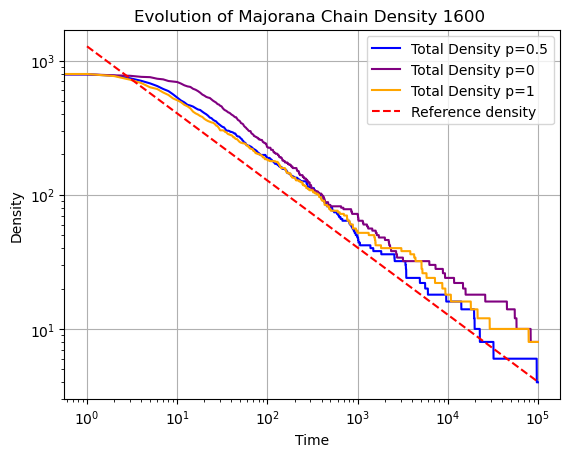

In [25]:
chain1 = chain_builder_2L(400, 4)
times1, density1 = evolution_annihilate_2L(chain1, 100000, 0.5)
chain2 = chain_builder_2L(400, 4)
times2, density2 = evolution_annihilate_2L(chain2, 100000, 0)
chain3 = chain_builder_2L(400, 4)
times3, density3 = evolution_annihilate_2L(chain3, 100000, 1)

density_ref = 1600*4/(math.sqrt(8 * math.pi) * np.sqrt(times1[1:])) 
# plt.plot(times1, (density1[:, 1]+ density1[:, 0]), label='Total Density', color='blue')

plt.plot(times1, (density1[:, 1]+ density1[:, 0]), label='Total Density p=0.5', color='blue')
plt.plot(times2, (density2[:, 1]+ density2[:, 0]), label='Total Density p=0', color='purple')
plt.plot(times3, (density3[:, 1]+ density3[:, 0]), label='Total Density p=1', color='orange')
plt.plot(times1[1:], density_ref, label='Reference density', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Density')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Evolution of Majorana Chain Density {len(chain1)} ')
# plt.xlim(0,6)
plt.legend()
plt.grid()
plt.show()


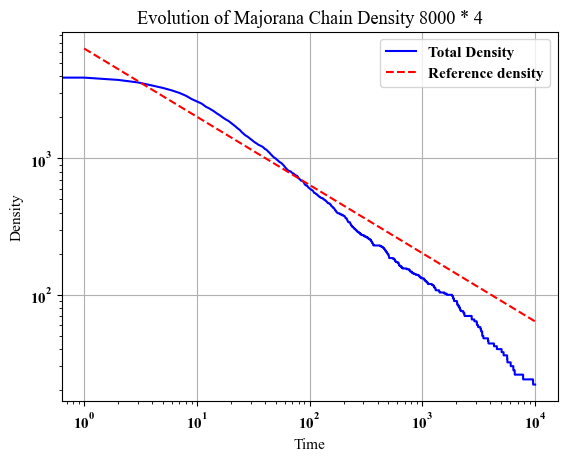

In [164]:
density_ref = 16000/(math.sqrt(2 * math.pi) * np.sqrt(times[1:])) 
plt.plot(times, density[:, 1]+ density[:, 0], label='Total Density', color='blue')
plt.plot(times[1:], density_ref, label='Reference density', color='red', linestyle='--')
plt.rcParams['font.family']    = 'serif'            # e.g. 'serif', 'sans-serif', 'monospace'
plt.rcParams['font.serif']     = ['Times New Roman'] # list of preferred serif fonts
plt.rcParams['font.size']      = 11                # default font size
plt.rcParams['font.weight']    = 'bold'             # can be 'normal', 'bold', etc.

plt.xlabel('Time')
plt.ylabel('Density')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Evolution of Majorana Chain Density {len(chain)} * 4')
# plt.xlim(0,6)
plt.legend()
plt.grid()
plt.show()

In [136]:
(density[10, 1] - density[2000, 1])/(1900)

np.float64(0.6631578947368421)

In [104]:
(density[10, 1] - density[2000, 1])/(1990)

np.float64(0.6331658291457286)

In [61]:
4/np.sqrt(8* np.pi ) 

np.float64(0.7978845608028654)

In [62]:
3/np.sqrt(8* np.pi ) 

np.float64(0.5984134206021491)

In [97]:
2/np.sqrt(8* np.pi )

np.float64(0.3989422804014327)

In [103]:
chain1 = chain_builder(600, 4)
# chain, density = hopping_annihilate(chain)
times1, density1 = evolution_annihilate(chain1, 2000, 0)


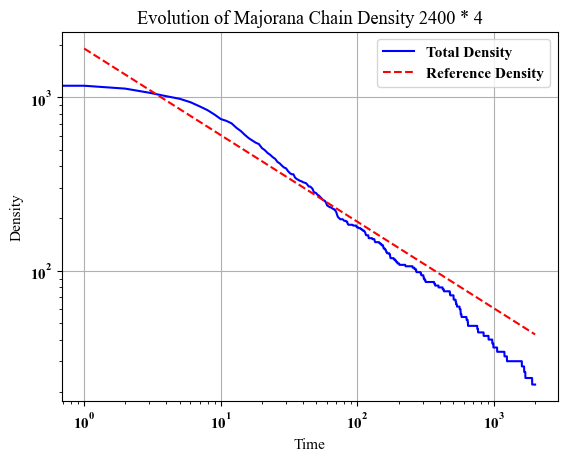

In [159]:
density_ref1 = 4800/(math.sqrt(2 * math.pi) * np.sqrt(times1[1:])) 
plt.plot(times1, density1[:, 1]+ density1[:, 0], label='Total Density', color='blue')
plt.plot(times1[1:], density_ref1, label='Reference Density', color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Density')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Evolution of Majorana Chain Density {len(chain1)} * 4')
# plt.xlim(0,6)
plt.legend()
plt.grid()
plt.show()

In [111]:
(density1[10, 0] - density1[400, 0])/(390)

np.float64(0.841025641025641)

In [121]:
chain2 = chain_builder(600, 4)
# chain, density = hopping_annihilate(chain)
times2, density2 = evolution_annihilate(chain2, 2000, 1)


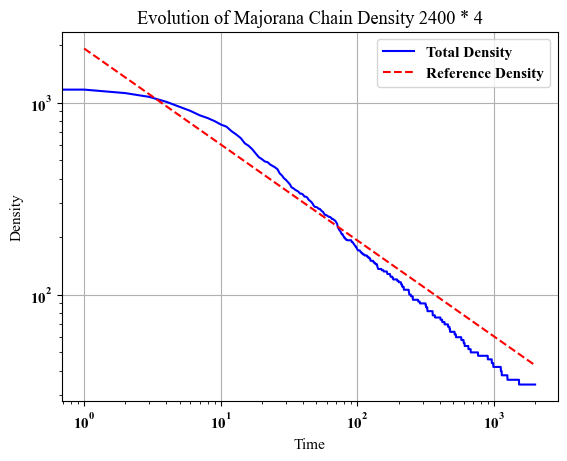

In [158]:
density_ref2 = 4800/(math.sqrt(2 * math.pi) * np.sqrt(times2[1:])) 
plt.plot(times2, density2[:, 1]+ density2[:, 0], label='Total Density', color='blue')
plt.plot(times2[1:], density_ref2, label='Reference Density', color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Density')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Evolution of Majorana Chain Density {len(chain2)} * 4')
# plt.xlim(0,6)
plt.legend()
plt.grid()
plt.show()

In [152]:
(density2[10, 0] - density2[500, 0])/(490)

np.float64(0.710204081632653)

In [143]:
chain3 = chain_builder(600, 4)
# chain, density = hopping_annihilate(chain)
times3, density3 = evolution_annihilate(chain3, 4000, 0.4)


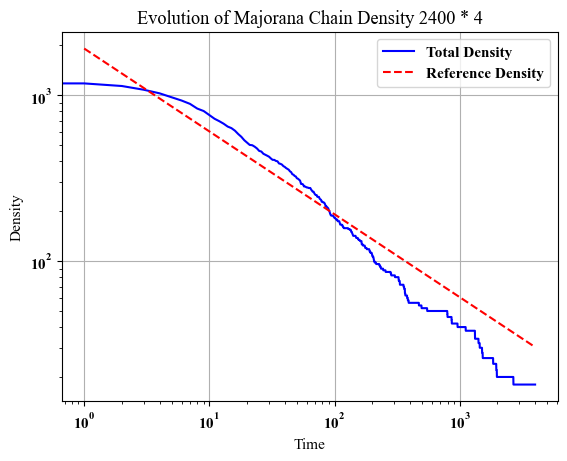

In [156]:
density_ref3 = 4800/(math.sqrt(2 * math.pi) * np.sqrt(times3[1:])) 

plt.plot(times3, density3[:, 1]+ density3[:, 0], label='Total Density', color='blue')
plt.plot(times3[1:], density_ref3, label='Reference Density', color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Density')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Evolution of Majorana Chain Density {len(chain3)} * 4')
# plt.xlim(0,6)
plt.legend()
plt.grid()
plt.show()

In [127]:
(density3[10, 1] - density3[400, 1])/(390)

np.float64(0.9128205128205128)

In [151]:
(density3[10, 0] - density3[500, 0])/(490)

np.float64(0.7061224489795919)